In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datasets
from build_dataset import *
import json
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'src'))
from utils import *
from interp_utils import *
from interp_vis import *

## patching on type inf data

In [3]:
comp_ds = datasets.load_dataset("franlucc/starcoderbase-1b-completions_typeinf_analysis", split="train")

In [4]:
incorrect = comp_ds.filter(lambda x: x["correctness"] == "incorrect")
correct = comp_ds.filter(lambda x: x["correctness"] == "correct")
correct_number = correct.filter(lambda x: x["solution"] == "number")

In [5]:
incorrect, correct, correct_number

(Dataset({
     features: ['generated', 'solution', 'hexsha', 'prompt', 'correctness', 'id'],
     num_rows: 1393
 }),
 Dataset({
     features: ['generated', 'solution', 'hexsha', 'prompt', 'correctness', 'id'],
     num_rows: 2296
 }),
 Dataset({
     features: ['generated', 'solution', 'hexsha', 'prompt', 'correctness', 'id'],
     num_rows: 491
 }))

In [6]:
model = "/home/arjun/models/starcoderbase-1b"
model = LanguageModel(model, device_map="cuda:3")

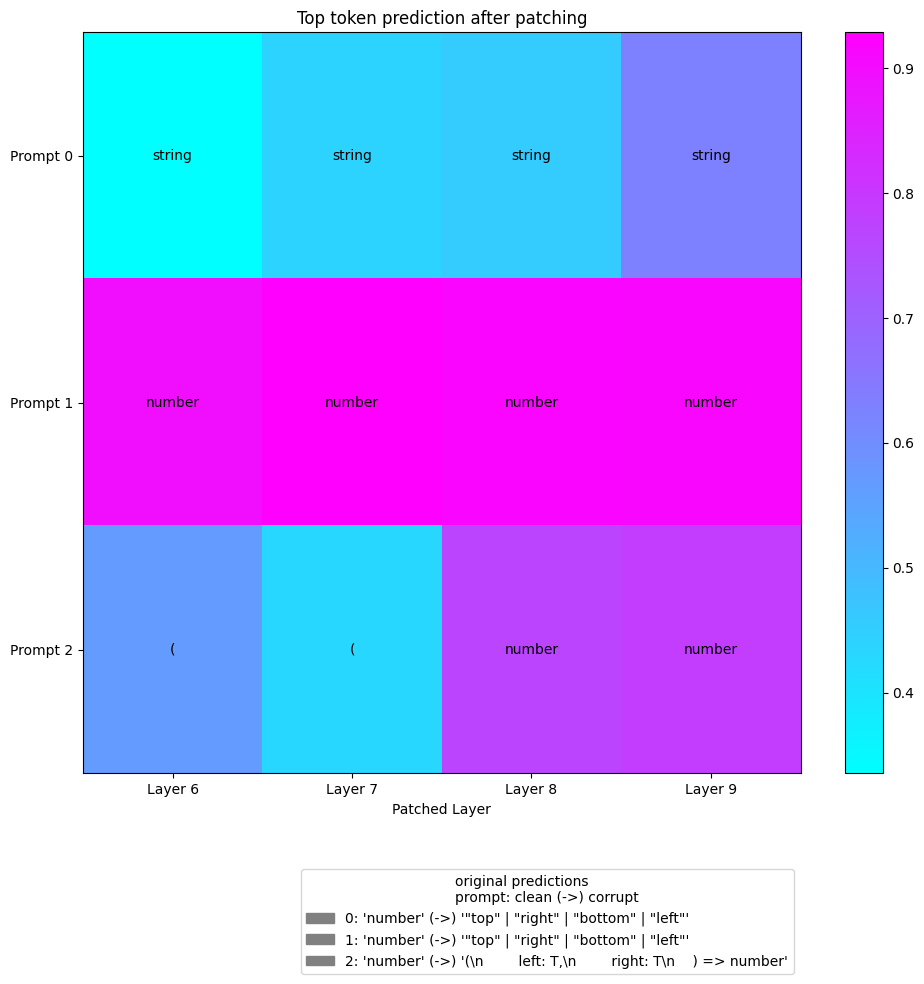

In [42]:
k = range(3)
cleans = [correct_number[i]["prompt"] for i in k]
corrs = [incorrect[i]["prompt"] for i in k]
incorrect_solns = [incorrect[i]["solution"] for i in k]
correct_solns = [correct_number[i]["solution"] for i in k]
annotations = list(zip(correct_solns, incorrect_solns))

patch_l = [6,7,8,9]
trace_results = []
for l in tqdm(patch_l):
    trace_res = patch_clean_to_corrupt(model, cleans, corrs, l)
    trace_results.append(trace_res)

patched_heatmap_prediction(model, cleans,corrs, trace_results, patch_l, 
                           figtitle="Top token prediction after patching", 
                           bbox_to_anchor=(1,-0.2), 
                           annotations=annotations, 
                           outfile=f"../data/results/patching/patch_{k[0]}_{k[-1]}_l-{'-'.join(map(str, patch_l))}.pdf"
                           )


In [51]:
# make a list of correct-incorrect where correct["solution"]==incorrect["solution"]
correct_incorrect = []
for c in tqdm(correct):
    for i in incorrect:
        if c["solution"] == i["solution"]:
            correct_incorrect.append((c,i))

with open("../data/correct_incorrect.json", "w") as f:
    json.dump(correct_incorrect, f)

100%|██████████| 2296/2296 [03:48<00:00, 10.04it/s]


100%|██████████| 4/4 [00:23<00:00,  5.89s/it]
/home/franlucc/projects/codetrace/interp_vis.py:128: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from current font.
  plt.tight_layout()
/home/franlucc/projects/codetrace/interp_vis.py:128: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/home/franlucc/projects/codetrace/interp_vis.py:129: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from current font.
  plt.savefig(outfile)
/home/franlucc/projects/codetrace/interp_vis.py:129: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.savefig(outfile)
/home/franlucc/projects/codetrace/interp_vis.py:129: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from current font.
  plt.savefig(outfile)
/home/franlucc/projects/codetrace/interp_vis.py:129: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.savefig(o

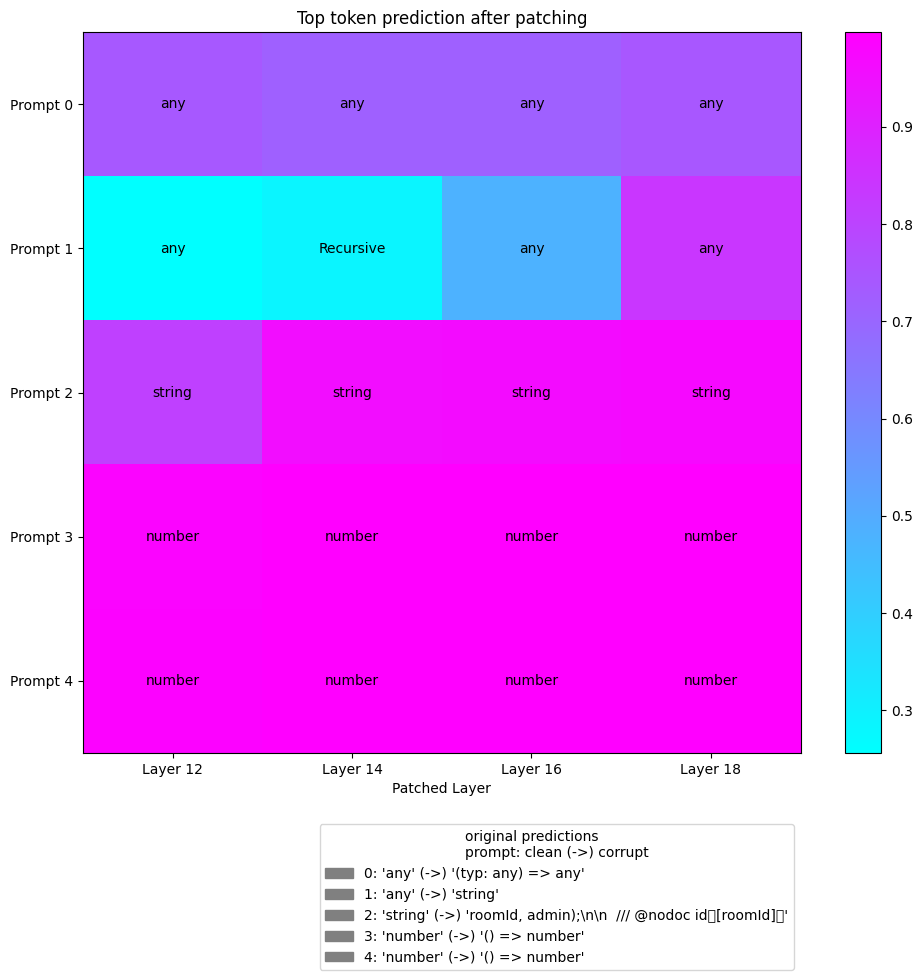

In [55]:
# import random
# seed=0
# random.seed(seed)
# # shuffle
# random.shuffle(correct_incorrect)

k = range(50,55)
cleans = [correct_incorrect[i][0]["prompt"] for i in k]
corrs = [correct_incorrect[i][1]["prompt"] for i in k]
correct_solns = [correct_incorrect[i][0]["solution"] for i in k]
incorrect_gen = [correct_incorrect[i][1]["generated"] for i in k]
annotations = list(zip(correct_solns, incorrect_gen))

patch_l = [12,14,16,18]
trace_results = []
for l in tqdm(patch_l):
    trace_res = patch_clean_to_corrupt(model, cleans, corrs, l)
    trace_results.append(trace_res)

patched_heatmap_prediction(model, cleans,corrs, trace_results, patch_l, 
                           figtitle="Top token prediction after patching", 
                           bbox_to_anchor=(1,-0.2), 
                           annotations=annotations, 
                           outfile=f"../data/results/patching/match_patch_s{seed}_{k[0]}_{k[-1]}_layers-{'-'.join(map(str, patch_l))}.pdf"
                           )

In [24]:
patches = layer_union(patches)

In [25]:
# res = logit_lens(model, correct_number[i]["prompt"])
# tokens = res.score_top(1).get_tokens(model, [-1],-1)
# print(res.logits.shape)
# argmax = torch.argmax(res.logits, dim=-1)[-1,0,-1]
# tokens, model.tokenizer.decode(argmax)

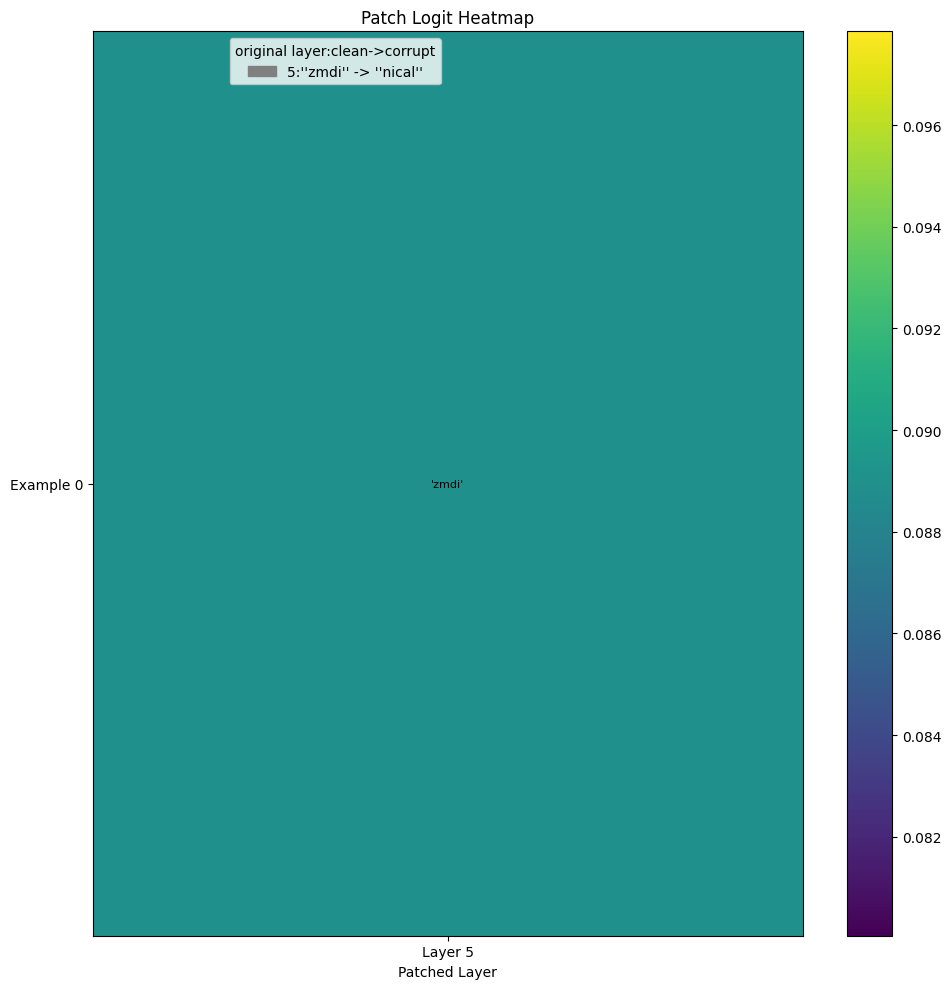

: 

In [26]:
patch_logit_heatmap(model, correct_number[i]["prompt"], incorrect[i]["prompt"], patches, layers, -1,-1)

## dataset building

In [3]:
ds = datasets.load_dataset("franlucc/stenotype-eval-dataset", split="train")

In [4]:
f_ds = filter_types_with_idx(ds, QUERY_FUNC_TYPES)
f_ds

Dataset({
    features: ['hexsha', 'size', 'ext', 'lang', 'max_stars_repo_path', 'max_stars_repo_name', 'max_stars_repo_head_hexsha', 'max_stars_repo_licenses', 'max_stars_count', 'max_stars_repo_stars_event_min_datetime', 'max_stars_repo_stars_event_max_datetime', 'max_issues_repo_path', 'max_issues_repo_name', 'max_issues_repo_head_hexsha', 'max_issues_repo_licenses', 'max_issues_count', 'max_issues_repo_issues_event_min_datetime', 'max_issues_repo_issues_event_max_datetime', 'max_forks_repo_path', 'max_forks_repo_name', 'max_forks_repo_head_hexsha', 'max_forks_repo_licenses', 'max_forks_count', 'max_forks_repo_forks_event_min_datetime', 'max_forks_repo_forks_event_max_datetime', 'content', 'avg_line_length', 'max_line_length', 'alphanum_fraction', 'annotation_sites', 'type_definitions', 'loc', 'functions', 'loc_per_function', 'estimated_tokens', 'fim_program', 'fim_type'],
    num_rows: 5370
})

In [5]:
i = 0
print(f_ds[i]["fim_program"])
print(f_ds[i]["fim_type"])

/*
 * @Author: your name
 * @Date: 2022-04-24 10:11:23
 * @LastEditTime: 2022-04-24 16:14:52
 * @LastEditors: Please set LastEditors
 * @Description: 打开koroFileHeader查看配置 进行设置: https://github.com/OBKoro1/koro1FileHeader/wiki/%E9%85%8D%E7%BD%AE
 * @FilePath: /tinkerbell-ui-react/src/packages/DaysPicker/date/interface.ts
 */
//  props 天
export interface dayProps {
    year: number;
    month: number;
    active: number;
    change: Function;
    visible: boolean;
    monthRef: any;
    show: boolean;
    limit: boolean;
}
//  props 月
export interface monthProps {
    visible: boolean;
    active: number;
    change: Function;
    year: number;
    plateChange: Function;
    limit: boolean;
}
//  props 年
export interface yearProps {
    visible: boolean;
    active: number;
    change: Function;
    plateChange: Function;
    limit: boolean;
}

// pageday-item type
export type dayItem = {
    label: string;
    value: number;
    disabled: boolean; //禁用
    prev: boolean; // 是否属于上一月份
    

In [7]:
f_ds.push_to_hub("franlucc/stenotype-eval-dataset-func-type-stripped-v3")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
f_ds_v0 = datasets.load_dataset("franlucc/stenotype-eval-func-type-stripped-v1", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/336 [00:00<?, ? examples/s]

In [9]:
count = 0
diffs = []
lens = []
for i in range(len(f_ds)):
    a =f_ds[i]["content_type_removed"]
    b=f_ds_v0[i]["content_type_removed"]
    if a != b:
        count += 1
        diffs.append((i,a, b))
        lens.append(len(a) - len(b))
        
count

0

In [25]:
ds = datasets.load_dataset("franlucc/stenotype-eval-dataset-func-type-stripped-v3", split="train")


In [26]:
fixds = ds.map(lambda x: {**x, "fim_type": json.loads(x["fim_type"]).strip()})

Map:   0%|          | 0/5370 [00:00<?, ? examples/s]

In [27]:
ds[3]["fim_type"]

'"number"'

In [28]:
fixds[3]["fim_type"]

'number'

In [33]:
fixds2.push_to_hub("franlucc/stenotype-eval-dataset-func-type-stripped-v4")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
fixds2 = fixds.filter(lambda x: "<FILL>" in x["fim_program"])

Filter:   0%|          | 0/5370 [00:00<?, ? examples/s]

In [34]:
fixds2[2019]["fim_type"]

'"top" | "right" | "bottom" | "left"'